c:\Users\Jonas\Desktop\spass_mit_python\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


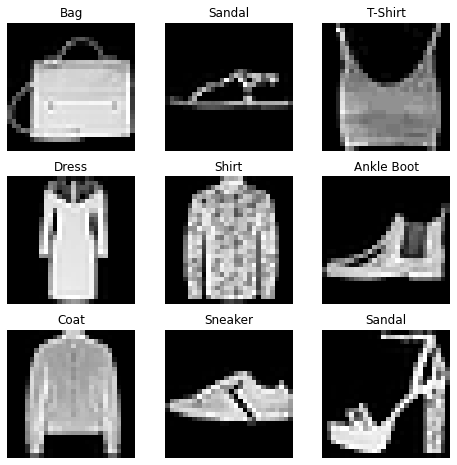

In [1]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from src.common.vectorize import one_hot
import matplotlib.pyplot as plt
import numpy as np


train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
n_classes = len(labels_map)

# to numpy representation
sample_size = train_dataset[0][0].numel()
sample_height, sample_width = 28, 28
train_data = np.zeros((len(train_dataset), 1, sample_height, sample_width))
train_labels = np.zeros(len(train_dataset), np.uint8)
for ix, (tensor, label) in enumerate(train_dataset):
    train_data[ix] = np.asarray(tensor).reshape((1, sample_height, sample_width))
    train_labels[ix] = label
train_labels_oh = one_hot(train_labels, n_classes)
test_data = np.zeros((len(test_dataset), 1, sample_height, sample_width))
test_labels = np.zeros(len(test_dataset), np.uint8)
for ix, (tensor, label) in enumerate(test_dataset):
    test_data[ix] = np.asarray(tensor).reshape((1, sample_height, sample_width))
    test_labels[ix] = label

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(train_dataset))
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [2]:
from src.neuronal_network.network import MLP, CNN
from src.neuronal_network.activation import ReLU, SoftMax
from src.neuronal_network.loss import CrossEntropy
from src.common.vectorize import one_hot
from src.neuronal_network.optimizer import Adam
import numpy as np
import tqdm


# hyper params
n_epochs = 4
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7
batch_size = 100


# Model
loss = CrossEntropy()
optimizer = lambda: Adam(learning_rate, beta1, beta2, epsilon)
cnn = CNN((sample_height, sample_width), n_classes, [(5,5)], [48,48], hidden_act=ReLU, output_act=SoftMax, optimizer=optimizer)

print(f"Model: {cnn}")

epoch_loss = np.zeros(n_epochs)
epoch_acc  = np.zeros(n_epochs)
epoch_weights = []

# training
with tqdm.tqdm(desc="Training", unit="epoch", total=n_epochs) as progress_bar:
  for epoch in range(n_epochs):
    perm = np.random.permutation(len(train_data))
    batch_data = np.split(train_data[perm], len(train_data)//batch_size)
    batch_labels = np.split(train_labels_oh[perm], len(train_labels_oh)//batch_size)

    for data, labels in zip(batch_data, batch_labels):
      pred = cnn.forward(data)
      epoch_loss[epoch] += loss(pred, labels).sum()
      cnn.fit()


    epoch_acc[epoch] = sum(cnn.classify(test_data) == test_labels) / len(test_data)
    progress_bar.set_postfix_str(f"loss={epoch_loss[epoch]:.02f}, acc={epoch_acc[epoch]*100:.02f}%")
    progress_bar.update(1)


# eval
fig = plt.figure(figsize=(8, 8), dpi=80)
fig.suptitle(str(cnn) + f", {loss} loss")
ax = fig.subplots(1)
ax.plot(epoch_loss, label="$\Sigma$loss", color="gray")
ax.set_xlabel("epoch")
ax_acc = ax.twinx()
ax_acc.plot(epoch_acc, label="acc", color="orange")
_ = fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_acc.transAxes)


Model: CNN


Training:   0%|          | 0/4 [00:00<?, ?epoch/s]

In [ ]:
test_classified = cnn.classify(test_data)
test_acc = sum(test_classified == test_labels) / len(test_data)

false_classified_ix = np.compress(test_classified != test_labels, np.arange(len(test_data)))

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Random selection of false classifications (Acc: {100*test_acc:.02f}%)")
figure.set_tight_layout(True)
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    ix = false_classified_ix[np.random.randint(0, len(false_classified_ix))]
    img, label = test_dataset[ix]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {labels_map[test_classified[ix]]}\n Lable: {labels_map[label]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

NameError: name 'mlp' is not defined

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
mlp.save(f"model/fashion_mlp_{timestamp}.pkl")

KeyboardInterrupt: 